In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def gen_1d_periodic_lattice(N, k):
    """
    Generate a 1D periodic lattice with N sites and k particles.
    """
    adj_list = {}
    for i in range(N):
        for j in range(k):
            if i not in adj_list:
                adj_list[i] = [(i+j+1)%N]
            else:
                adj_list[i].append((i+j+1)%N)
            adj_list[i].append((i-j-1)%N)

    return nx.Graph(adj_list)


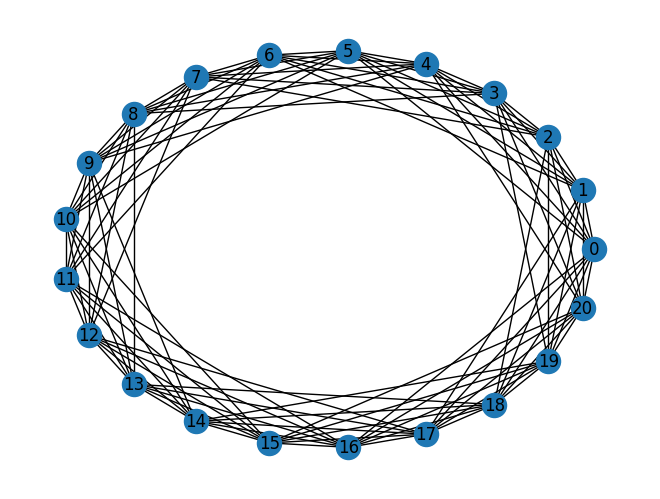

In [4]:
g = gen_1d_periodic_lattice(21, 5)
nx.draw(g, pos=nx.layout.circular_layout(g), with_labels=True)

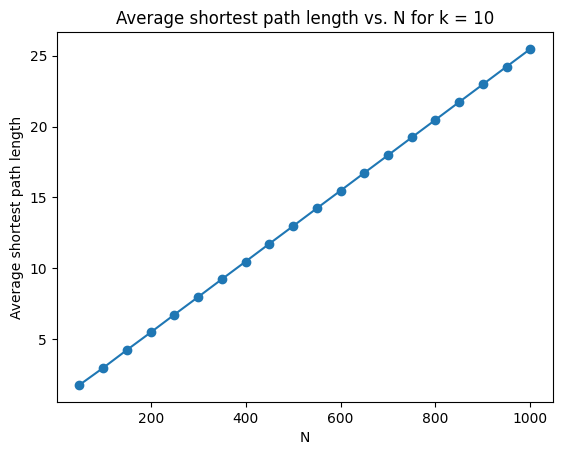

In [14]:
k = 10
N = range(50, 1001, 50)
p = []
for n in N:
    g = gen_1d_periodic_lattice(n, k)
    p.append(nx.average_shortest_path_length(g))

plt.xlabel("N")
plt.ylabel("Average shortest path length")
plt.title("Average shortest path length vs. N for k = 10")

plt.plot(N, p, marker='o', linestyle='-')

What is the relation between the average distance and the number of nodes?

A linear relation can be drawn, approximately $f(N) = \frac{N}{40}$ for a constant $k = 10$.


Does it meet your expectations? Provide an interpretation of the plot.

Yes, it does. The observed linear relation aligns with the formula for the average distance $\langle d_{i,j} \rangle = \frac{n-1+2k}{4k}$. For $k=10$, this becomes:


$\langle d_{i,j} \rangle = \frac{n+19}{40}$

and as $n$ approaches infinity:

$\lim_{{n \to \infty}} \left( \frac{n+19}{40} \right) = \frac{n}{40}$

In [18]:
import random
random.seed(0)

def watts_strogatz(N, k, p):
    """
    Generate a Watts-Strogatz graph with N nodes, k nearest neighbors, and rewiring probability p.
    """
    g = gen_1d_periodic_lattice(N, k)
    for i in range(N):
        for j in range(k):
            if random.random() < p:
                new_neighbor = random.choice(list(g.nodes - {i, (i + j + 1) % N, (i - j - 1) % N}))
                g.remove_edge(i, (i + j + 1) % N)
                g.add_edge(i, random.randint(0, new_neighbor))
    return g

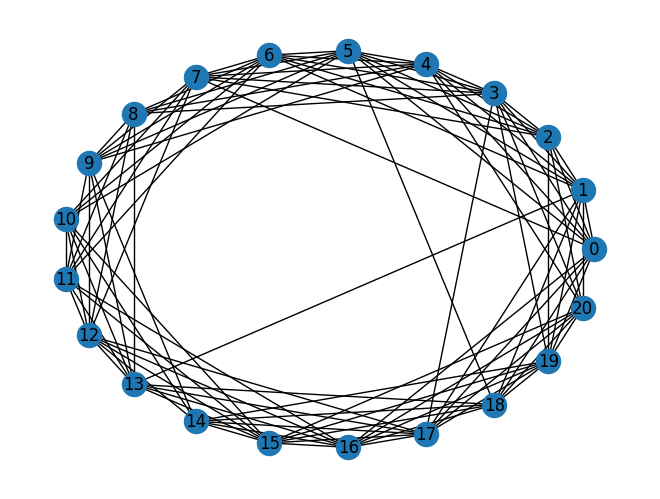

In [19]:
N = 21
k = 5
p = 0.1

g = watts_strogatz(N, k, p)
nx.draw(g, pos=nx.layout.circular_layout(g), with_labels=True)

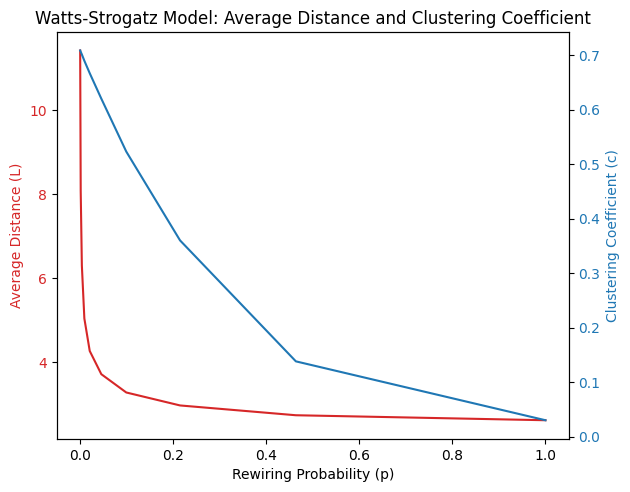

In [24]:
def compute_l_and_c(graph):
    """
    Compute average distance (L) and global clustering coefficient (c) for a given graph.
    """
    N = len(graph.nodes)
    
    # Check for connected graph to avoid outliers
    if not nx.is_connected(graph):
        return None, None
    
    # Compute average distance (L)
    avg_distance = nx.average_shortest_path_length(graph)
    
    # Compute global clustering coefficient (c)
    clustering_coefficient = nx.average_clustering(graph)
    
    return avg_distance, clustering_coefficient

def compute_avg_l_and_c(N, k, num_samples=100):
    """
    Compute average distance (L) and global clustering coefficient (c) for a range of rewiring probabilities.
    """
    rewiring_probabilities = np.logspace(-3, 0, num_samples)  # Logarithmic spacing for p
    avg_distances = []
    clustering_coefficients = []

    for p in rewiring_probabilities:
        avg_distance_sum = 0
        clustering_coefficient_sum = 0

        for _ in range(num_samples):
            # Generate Watts-Strogatz graph
            ws_graph = watts_strogatz(N, k, p)

            # Compute L and c for the graph
            avg_distance, clustering_coefficient = compute_l_and_c(ws_graph)

            # Add to sums if the graph is connected
            if avg_distance is not None and clustering_coefficient is not None:
                avg_distance_sum += avg_distance
                clustering_coefficient_sum += clustering_coefficient

        # Compute averages
        avg_distances.append(avg_distance_sum / num_samples)
        clustering_coefficients.append(clustering_coefficient_sum / num_samples)

    return rewiring_probabilities, avg_distances, clustering_coefficients

# Set parameters
N = 1000
k = 10
num_samples = 10

# Compute average distance (L) and global clustering coefficient (c)
p_values, avg_distances, clustering_coefficients = compute_avg_l_and_c(N, k, num_samples)

# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Rewiring Probability (p)')
ax1.set_ylabel('Average Distance (L)', color=color)
ax1.plot(p_values, avg_distances, color=color, label='L')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Clustering Coefficient (c)', color=color)  
ax2.plot(p_values, clustering_coefficients, color=color, label='c')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Watts-Strogatz Model: Average Distance and Clustering Coefficient')
plt.show()
